In [1]:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()
import pandas as pd

import json
import glob
import os
import re

pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [3]:
base = "../exp/"
datasets = { num: [json.load(open(path)) for path in glob.glob(base + f"compression/{num}/*.json")] for num in [10, 20, 30, 40, 50, 60, 70, 80, 90] }

In [9]:
queries = pd.DataFrame.from_records([{
    **algo,
    'potential': run['potential'],
    'graph': run['args'][1],
    'num_metrics': num_metrics,
} for (num_metrics, data) in datasets.items() for run in data for algo in run['algo_runs']])

<AxesSubplot:xlabel='num_metrics', ylabel='running_time_ms'>

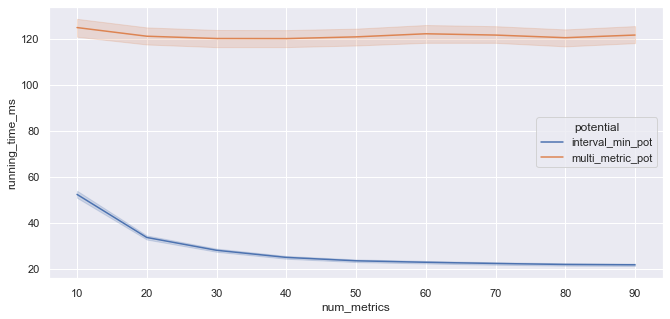

In [17]:
plt.figure(figsize=(11,5))
sns.lineplot(data=queries.loc[lambda x: x['graph'].str.contains('osm')], x='num_metrics', y='running_time_ms', hue='potential')

<AxesSubplot:xlabel='num_metrics', ylabel='running_time_ms'>

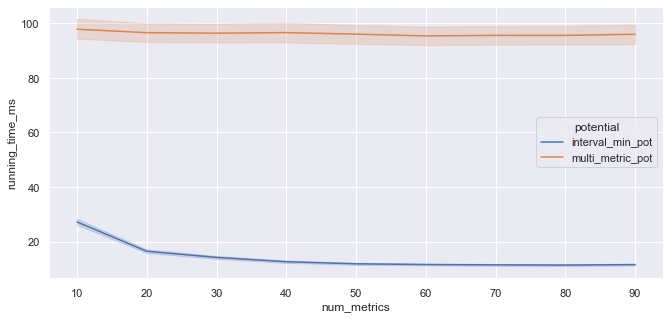

In [15]:
plt.figure(figsize=(11,5))
sns.lineplot(data=queries.loc[lambda x: x['graph'].str.contains('ptv')], x='num_metrics', y='running_time_ms', hue='potential')